In [ ]:
import warnings
import os
import pickle
import torch

import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq

from plotting import get_pred_perf_variability
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import seaborn as sns
from locale import normalize
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score, homogeneity_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")
seed = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
pre_datapath = "../../output/preprocessed_dataset/merfish_moffit.pkl"
output_root = "../../output/"

with open(pre_datapath, 'rb') as infile:
    spa_adata, scrna_adata, raw_spatial_df, raw_scrna_df, raw_shared_gene = pickle.load(infile)

df_spa = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)
imp_adatas = {}
eval_res = {'pred_corr':{}}
for file in os.listdir(output_root):
    if file.split('_')[-1].split('.')[0] not in {'spaGE', 'TransImpLR', 'stPlus', 'Tangram', 'TransImpCls'}: continue
    if len(file.split(".")[0].split('_')) != 3: continue    
    spa, rna, method = file.split(".")[0].split('_')
    if spa.lower() != 'merfish': continue
    df_res = pd.read_csv(os.path.join(output_root,file), index_col=0)
    imp_adata = sc.AnnData(df_res.values)
    imp_adata.var_names = df_res.columns
    imp_adata.obsm['spatial'] = spa_adata.obsm['spatial']
    
    imp_adatas[method] = imp_adata 
    corrs = calc_corr(df_spa, df_res, df_res.columns, False, True)
    sq.gr.spatial_neighbors(imp_adata)
    sq.gr.spatial_autocorr(
        imp_adata,
        n_jobs=20,
        mode='moran',
    )
    sel = (~np.isnan(imp_adata.uns['moranI'].I))
    if np.sum(sel) < imp_adata.n_vars:
        print(f'({spa} {rna} {method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    eval_res['pred_corr'][method] = pd.Series(corrs, df_res.columns)


In [3]:
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))

In [4]:
df_gene_var = get_pred_perf_variability(pre_datapath, seed, device)
df_gene_var.to_csv("../../output/performance_uncertainty/merfish.csv")
better_genes = df_gene_var.query(f'perf_var < {np.quantile(df_gene_var.perf_var, 0.5)}').gene.values
df_corr['TransImp(Top50%)'] = np.nan
df_corr.loc[better_genes, 'TransImp(Top50%)'] = df_corr.loc[better_genes, 'TransImpLR']

[TransImp] Epoch: 2000/2000, loss: 0.416934, (IMP) 0.416934: 100%|██████████| 2000/2000 [00:21<00:00, 94.98it/s] 
[TransImp] Epoch: 2000/2000, loss: 0.423438, (IMP) 0.423438: 100%|██████████| 2000/2000 [00:17<00:00, 117.47it/s]
[TransImp] Epoch: 2000/2000, loss: 0.355665, (IMP) 0.355665: 100%|██████████| 2000/2000 [00:16<00:00, 118.10it/s]
[TransImp] Epoch: 2000/2000, loss: 0.429266, (IMP) 0.429266: 100%|██████████| 2000/2000 [00:16<00:00, 118.22it/s]
[TransImp] Epoch: 2000/2000, loss: 0.413950, (IMP) 0.413950: 100%|██████████| 2000/2000 [00:17<00:00, 116.99it/s]


Tangram             0.552862
TransImpCls         0.560377
TransImpLR          0.561855
spaGE               0.545629
stPlus              0.549953
TransImp(Top50%)    0.718181
dtype: float64


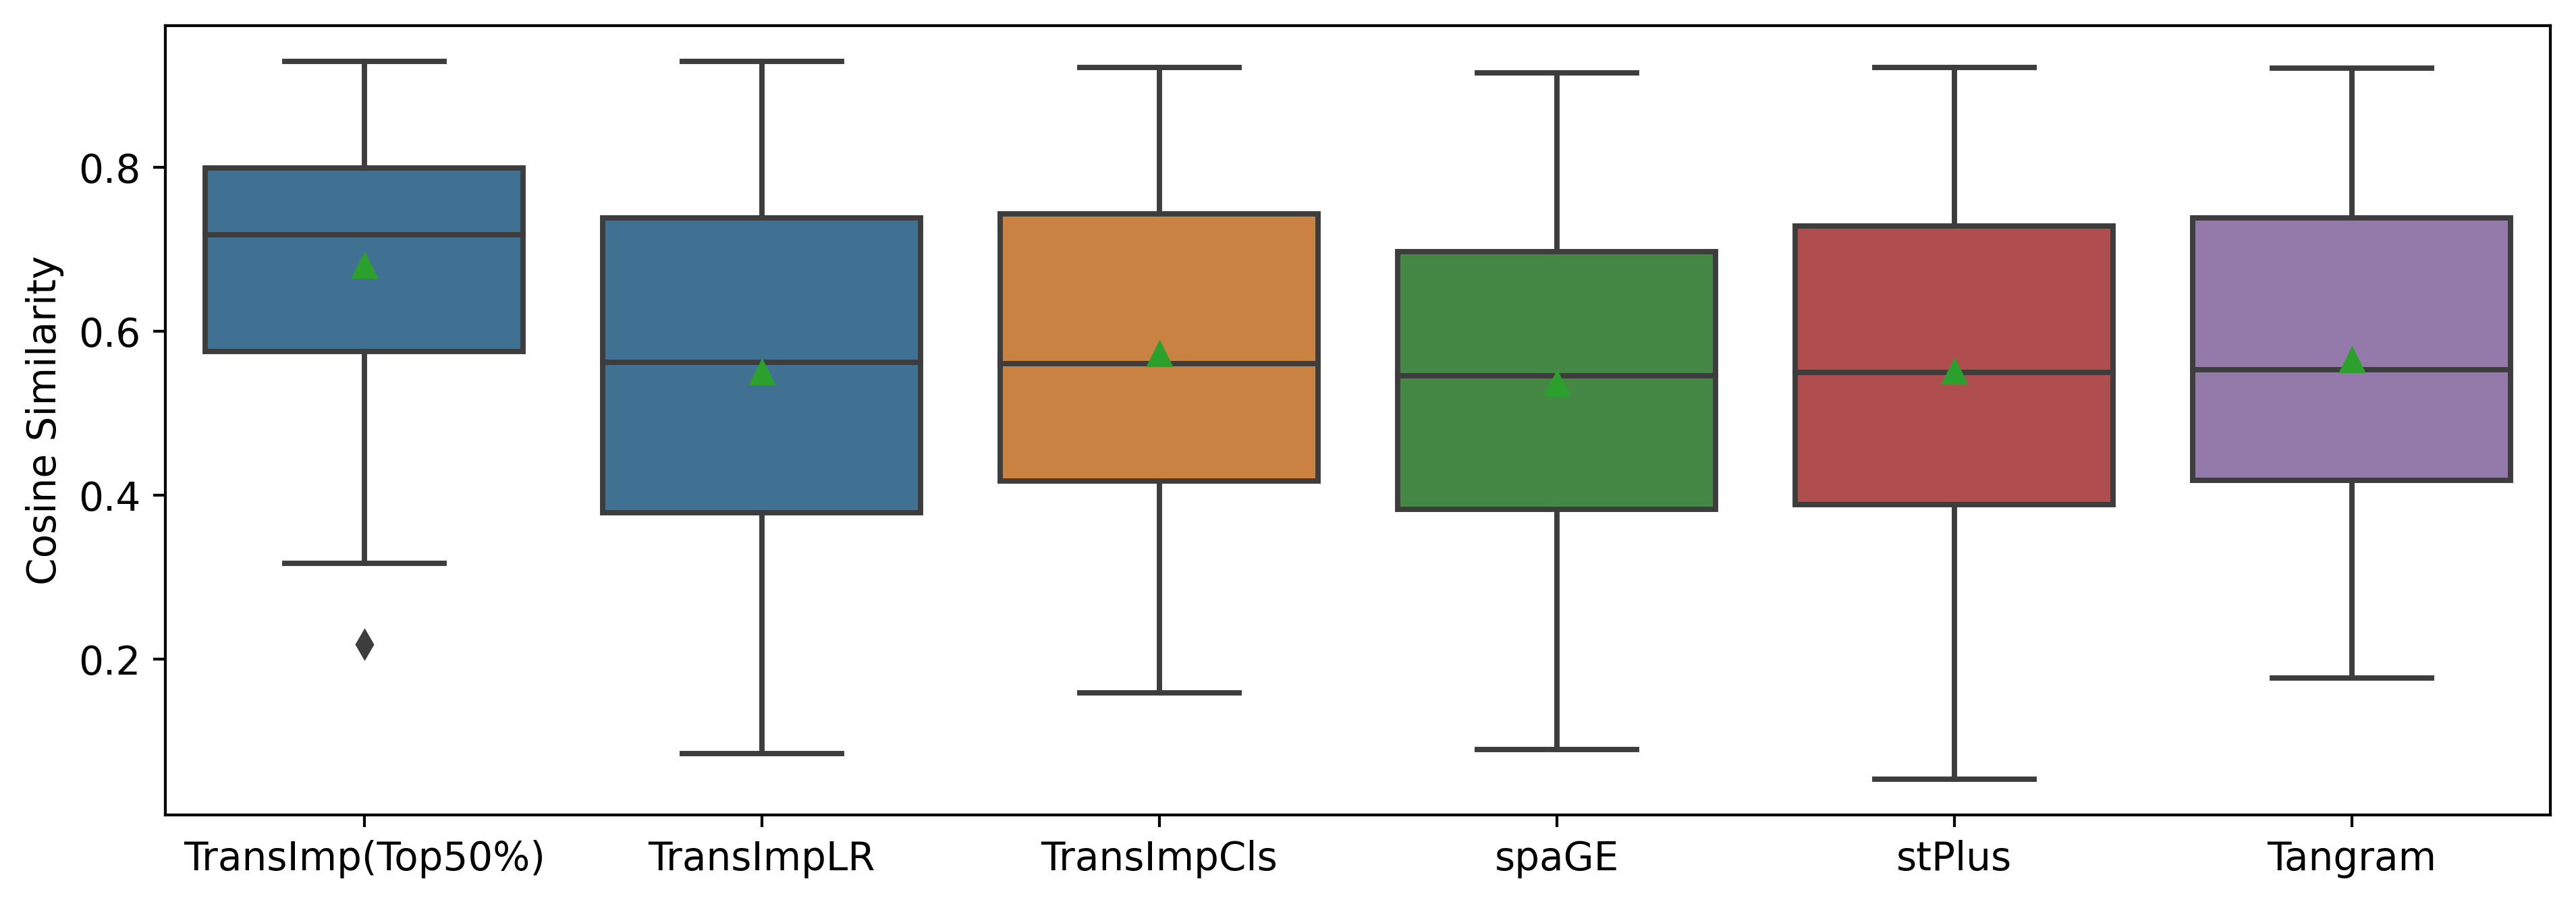

In [5]:
plt.figure(figsize=(12, 4), dpi= 380)
plt.rcParams.update({"font.size":11, 'axes.titlesize':12})
method_order = ["TransImp(Top50%)", "TransImpLR", "TransImpCls", "spaGE", "stPlus", "Tangram"]
color = ['#3274A1', '#3274A1', '#E1812C', '#3A923A', '#C03D3E', '#9372B2', '#845B53', '#D684BD', '#c780e8']
sns.boxplot(data = df_corr, showmeans=True, order=method_order[:6], palette=color[:6]).set(
    ylabel="Cosine Similarity"
)
print(df_corr.median())

In [ ]:
n_clusters = len(spa_adata.obs.cell_class.unique())
print(f"{n_clusters} clusters")

real_clss = AgglomerativeClustering(n_clusters=n_clusters, 
                                    connectivity=spa_adata.obsp['spatial_connectivities'],
                                    ).fit_predict(StandardScaler().fit_transform(spa_adata.X))
spa_cluster_metrics = {}
for method in sorted(imp_adatas.keys()):
    imp_adata = imp_adatas[method]
    pred_clss = AgglomerativeClustering(n_clusters=n_clusters, 
                                         connectivity=spa_adata.obsp['spatial_connectivities'],
                                         ).fit_predict(StandardScaler().fit_transform(imp_adata.X))
    ars = adjusted_rand_score(real_clss, pred_clss)
    amis = adjusted_mutual_info_score(real_clss, pred_clss)
    homo = homogeneity_score(real_clss, pred_clss)
    nmi = normalized_mutual_info_score(real_clss, pred_clss)
    spa_cluster_metrics[method] = {"ARS":ars, "AMIS":amis, 'HOMO': homo, 'NMI':nmi}
    pd.DataFrame(spa_cluster_metrics).to_csv("../../output/clustering/merfish_moffit.csv")
    print(f"Cluster on Raw Expression vs  on {method} Predicted Expression\n - ARS: {ars:.6f}, AMIS: {amis:.6f}, HOMO: {homo:.6f}, NMI: {nmi:.6f}")

15 clusters
Cluster on Raw Expression vs  on Tangram Predicted Expression
 - ARS: 0.510447, AMIS: 0.648975, HOMO: 0.713660, NMI: 0.649215
Cluster on Raw Expression vs  on TransImpCls Predicted Expression
 - ARS: 0.085691, AMIS: 0.342774, HOMO: 0.294706, NMI: 0.343357
Cluster on Raw Expression vs  on TransImpLR Predicted Expression
 - ARS: 0.522071, AMIS: 0.675620, HOMO: 0.713939, NMI: 0.675853
